Starting this with a lookback of the teams that have won the whole thing 

In [137]:
import pandas as pd
import numpy as np

# Sample data creation for demonstration.
# Assuming the real CSV file is named 'basketball_games.csv' and contains the mentioned columns.
data = pd.read_csv('MNCAATourneyDetailedResults.csv')
# Creating a DataFrame from the sample data
df = pd.DataFrame(data)

# Filtering for seasons greater than 2010
filtered_df = df[df['Season'] > 2003]

# Finding the WTeamID with the maximum DayNum for each distinct Season
result_df = filtered_df.loc[filtered_df.groupby('Season')['DayNum'].idxmax(), ['Season', 'DayNum', 'WTeamID']]

result_df


,Season,DayNum,WTeamID
127,2004,154,1163
191,2005,154,1314
255,2006,154,1196
319,2007,154,1196
383,2008,154,1242
447,2009,154,1314
511,2010,154,1181
578,2011,154,1163
645,2012,154,1246
712,2013,154,1257


In [138]:
conf_df = pd.read_csv('MconferenceTourneyGames.csv')
# conf_df =  conf_df[conf_df['ConfAbbrev'] == "big_east"]
conf_df_filtered = conf_df[conf_df['Season'] > 2003]


unique_confs = conf_df_filtered[['Season', 'ConfAbbrev']].drop_duplicates()

# For each unique season and conference pair, find the champion, runner-up, semifinalists, and quarterfinalists.
def tournament_details(row, df):
    season = row['Season']
    conf = row['ConfAbbrev']
    conf_games = df[(df['Season'] == season) & (df['ConfAbbrev'] == conf)]
    max_day = conf_games['DayNum'].max()
    champ_game = conf_games[conf_games['DayNum'] == max_day]
    champion = champ_game['WTeamID'].values[0]
    runner_up = champ_game['LTeamID'].values[0]
    semifinal_day = max_day - 1
    quarterfinal_day = max_day - 2
    semifinalists = conf_games[conf_games['DayNum'] == semifinal_day]['LTeamID'].tolist()
    quarterfinalists = conf_games[conf_games['DayNum'] == quarterfinal_day]['LTeamID'].tolist()
    return pd.Series([champion, runner_up, semifinalists, quarterfinalists])

# Apply the function to each unique conference-season pair
unique_confs[['Champion', 'RunnerUp', 'Semifinalists', 'Quarterfinalists']] = unique_confs.apply(lambda row: tournament_details(row, conf_df_filtered), axis=1)

# Merge this tournament detail with the main result DataFrame on Season
final_df_enhanced = pd.merge(result_df, unique_confs, on=['Season'], how='left')

final_df_enhanced


,Season,DayNum,WTeamID,ConfAbbrev,Champion,RunnerUp,Semifinalists,Quarterfinalists
0,2004,154,1163,a_sun,1416,1407,"[1209, 1125]","[1273, 1391, 1194, 1239]"
1,2004,154,1163,a_ten,1462,1173,"[1350, 1203]","[1182, 1348, 1396, 1386]"
2,2004,154,1163,acc,1268,1181,"[1210, 1301]","[1438, 1314, 1448, 1199]"
3,2004,154,1163,aec,1436,1263,[],[]
4,2004,154,1163,big_east,1163,1338,"[1437, 1130]","[1393, 1323, 1439, 1344]"
...,...,...,...,...,...,...,...,...
583,2023,154,1163,summit,1331,1295,"[1355, 1472]","[1377, 1442]"
584,2023,154,1163,sun_belt,1418,1375,"[1241, 1402]","[1407, 1379, 1267, 1204]"
585,2023,154,1163,swac,1411,1212,"[1238, 1105]","[1380, 1341]"
586,2023,154,1163,wac,1213,1381,"[1358, 1430]","[1370, 1465, 1469, 1470]"


In [139]:
tournament_results_df = unique_confs[['Season', 'ConfAbbrev', 'Champion', 'RunnerUp', 'Semifinalists', 'Quarterfinalists']].copy()

def determine_tournament_position_v2(row):
    season = row['Season']
    team_id = row['WTeamID']
    tournament_info = tournament_results_df[tournament_results_df['Season'] == season]

    # Initialize variables
    conf = None
    position = None

    # Check for champion, runner-up, semifinalist, quarterfinalist by iterating through the rows
    for _, t_row in tournament_info.iterrows():
        # Direct match for Champion and RunnerUp
        if team_id == t_row['Champion']:
            conf = t_row['ConfAbbrev']
            position = 'Champion'
            break
        elif team_id == t_row['RunnerUp']:
            conf = t_row['ConfAbbrev']
            position = 'RunnerUp'
            break
        # Check within lists for Semifinalists and Quarterfinalists
        elif any(team_id == semi_id for semi_id in t_row['Semifinalists']):
            conf = t_row['ConfAbbrev']
            position = 'Semifinalist'
            break
        elif any(team_id == quarter_id for quarter_id in t_row['Quarterfinalists']):
            conf = t_row['ConfAbbrev']
            position = 'Quarterfinalist'
            break

    return pd.Series([conf, position])

# Re-apply the corrected function to the results dataframe
result_df[['ConfAbbrev', 'TournamentResult']] = result_df.apply(determine_tournament_position_v2, axis=1)

result_df

,Season,DayNum,WTeamID,ConfAbbrev,TournamentResult
127,2004,154,1163,big_east,Champion
191,2005,154,1314,acc,Semifinalist
255,2006,154,1196,sec,Champion
319,2007,154,1196,sec,Champion
383,2008,154,1242,big_twelve,Champion
447,2009,154,1314,acc,Semifinalist
511,2010,154,1181,acc,Champion
578,2011,154,1163,big_east,Champion
645,2012,154,1246,sec,RunnerUp
712,2013,154,1257,big_east,Champion


In [140]:
df = final_df_enhanced

# Remove the 'WTeamID' and 'DayNum' columns
df.drop(columns=['WTeamID', 'DayNum'], inplace=True)

# Initialize a list to hold the new row-wise data
rows = []

# Iterate over each row in the dataframe to transform and accumulate the data
for _, row in df.iterrows():
    season, conf = row['Season'], row['ConfAbbrev']
    # Champion
    rows.append([season, conf, 'Champion', row['Champion']])
    # RunnerUp
    rows.append([season, conf, 'RunnerUp', row['RunnerUp']])
    # Semifinalists
    for team in row['Semifinalists']:
        rows.append([season, conf, 'Semifinalist', team])
    # Quarterfinalists
    for team in row['Quarterfinalists']:
        rows.append([season, conf, 'Quarterfinalist', team])

# Create a new DataFrame from the rows list
df_transformed = pd.DataFrame(rows, columns=['Season', 'ConfAbbrev', 'ConfTournamentPlace', 'TeamID'])

df_transformed.head(200)

,Season,ConfAbbrev,ConfTournamentPlace,TeamID
0,2004,a_sun,Champion,1416
1,2004,a_sun,RunnerUp,1407
2,2004,a_sun,Semifinalist,1209
3,2004,a_sun,Semifinalist,1125
4,2004,a_sun,Quarterfinalist,1273
...,...,...,...,...
195,2005,a_sun,Quarterfinalist,1209
196,2005,a_sun,Quarterfinalist,1407
197,2005,a_sun,Quarterfinalist,1252
198,2005,a_sun,Quarterfinalist,1273


In [141]:
games_df = data

team_season_games = games_df.groupby(['Season', 'WTeamID']).size().reset_index(name='Wins').rename(columns={'WTeamID': 'TeamID'})
team_season_losses = games_df.groupby(['Season', 'LTeamID']).size().reset_index(name='Losses').rename(columns={'LTeamID': 'TeamID'})

# Merge the win and loss counts on Season and TeamID, filling missing values with 0
team_games_combined = pd.merge(team_season_games, team_season_losses, on=['Season', 'TeamID'], how='outer').fillna(0)

# Calculate total games played
team_games_combined['GamesPlayed'] = team_games_combined['Wins'] + team_games_combined['Losses']

# Drop the Wins and Losses columns as they are not required for the final output
team_games_combined.drop(columns=['Wins', 'Losses'], inplace=True)

team_games_combined

,Season,TeamID,GamesPlayed
0,2003,1112,4.0
1,2003,1113,2.0
2,2003,1120,3.0
3,2003,1139,3.0
4,2003,1141,2.0
...,...,...,...
1330,2023,1429,1.0
1331,2023,1433,1.0
1332,2023,1436,1.0
1333,2023,1438,1.0


In [142]:
conf_tourney_competitors_ncaa_tourney_results = pd.merge(df_transformed,team_games_combined, on=['Season', 'TeamID'], how='inner')
print(conf_tourney_competitors_ncaa_tourney_results )

      Season ConfAbbrev ConfTournamentPlace  TeamID  GamesPlayed
0       2004      a_sun            Champion    1416          1.0
1       2004      a_ten            Champion    1462          4.0
2       2004      a_ten            RunnerUp    1173          1.0
3       2004      a_ten        Semifinalist    1350          1.0
4       2004      a_ten     Quarterfinalist    1386          4.0
...      ...        ...                 ...     ...          ...
1201    2023   sun_belt            Champion    1418          1.0
1202    2023       swac            Champion    1411          1.0
1203    2023        wac            Champion    1213          1.0
1204    2023        wcc            Champion    1211          4.0
1205    2023        wcc            RunnerUp    1388          2.0

[1206 rows x 5 columns]


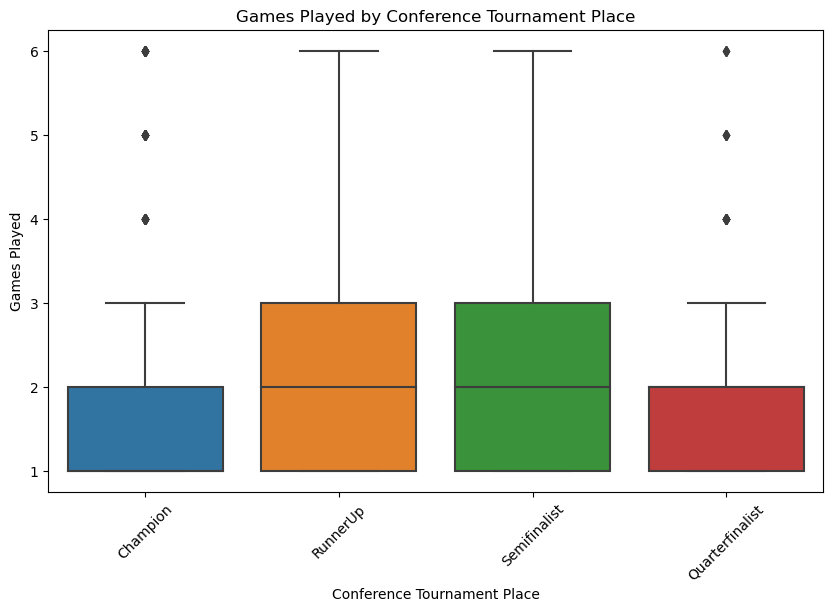

In [143]:

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=conf_tourney_competitors_ncaa_tourney_results, x='ConfTournamentPlace', y='GamesPlayed')
plt.title('Games Played by Conference Tournament Place')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Games Played')
plt.xticks(rotation=45)
plt.show()

In [144]:
teamSeeds_df = pd.read_csv('MNCAATourneySeeds.csv')
teamSeeds_df['SeedNum'] = teamSeeds_df['Seed'].str.extract('(\d+)').astype(int)

# Filter the DataFrame for rows where the seed number is less than 8
teamSeeds_df = teamSeeds_df[teamSeeds_df['SeedNum'] < 17]

# Drop the temporary SeedNum column if no longer needed
# teamSeeds_df = filtered_df.drop(columns=['SeedNum'])

filtered_df
print(teamSeeds_df)



      Season Seed  TeamID  SeedNum
0       1985  W01    1207        1
1       1985  W02    1210        2
2       1985  W03    1228        3
3       1985  W04    1260        4
4       1985  W05    1374        5
...      ...  ...     ...      ...
2485    2023  Z12    1433       12
2486    2023  Z13    1233       13
2487    2023  Z14    1213       14
2488    2023  Z15    1421       15
2489    2023  Z16    1224       16

[2490 rows x 4 columns]


In [145]:
top8conftourneyResults = pd.merge(conf_tourney_competitors_ncaa_tourney_results,teamSeeds_df, on=['Season', 'TeamID'], how='inner')
print(top8conftourneyResults)

      Season ConfAbbrev ConfTournamentPlace  TeamID  GamesPlayed  Seed  \
0       2004      a_sun            Champion    1416          1.0   Y14   
1       2004      a_ten            Champion    1462          4.0   W07   
2       2004      a_ten            RunnerUp    1173          1.0   X10   
3       2004      a_ten        Semifinalist    1350          1.0   Y11   
4       2004      a_ten     Quarterfinalist    1386          4.0   Y01   
...      ...        ...                 ...     ...          ...   ...   
1201    2023   sun_belt            Champion    1418          1.0   W13   
1202    2023       swac            Champion    1411          1.0  W16b   
1203    2023        wac            Champion    1213          1.0   Z14   
1204    2023        wcc            Champion    1211          4.0   Z03   
1205    2023        wcc            RunnerUp    1388          2.0   Z05   

      SeedNum  
0          14  
1           7  
2          10  
3          11  
4           1  
...       ...  

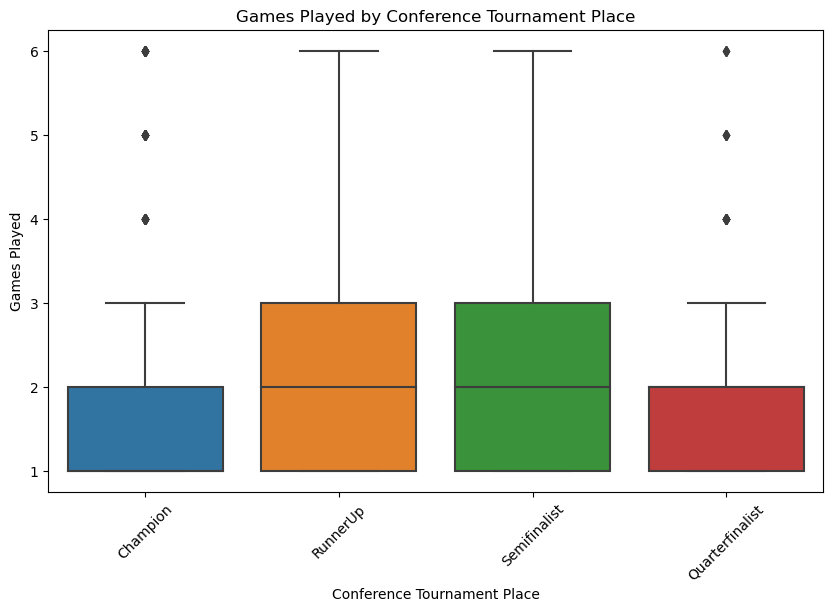

In [146]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(10, 6))
sns.boxplot(data=top8conftourneyResults, x='ConfTournamentPlace', y='GamesPlayed')
plt.title('Games Played by Conference Tournament Place')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Games Played')
plt.xticks(rotation=45)
plt.show()

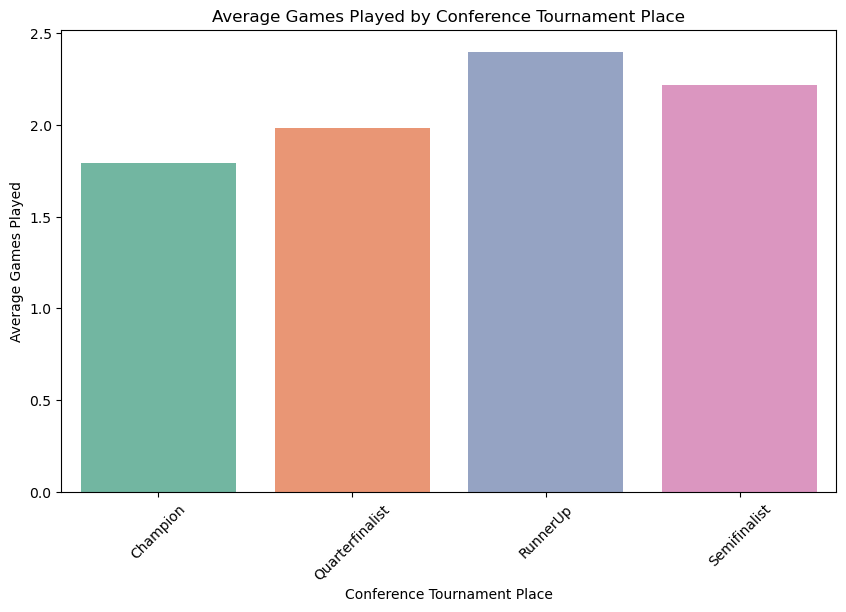

In [147]:
avg_games_played = top8conftourneyResults.groupby('ConfTournamentPlace')['GamesPlayed'].mean().reset_index()

# Plotting the average games played
plt.figure(figsize=(10, 6))
sns.barplot(data=avg_games_played, x='ConfTournamentPlace', y='GamesPlayed', palette="Set2")
plt.title('Average Games Played by Conference Tournament Place')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Average Games Played')
plt.xticks(rotation=45)
plt.show()

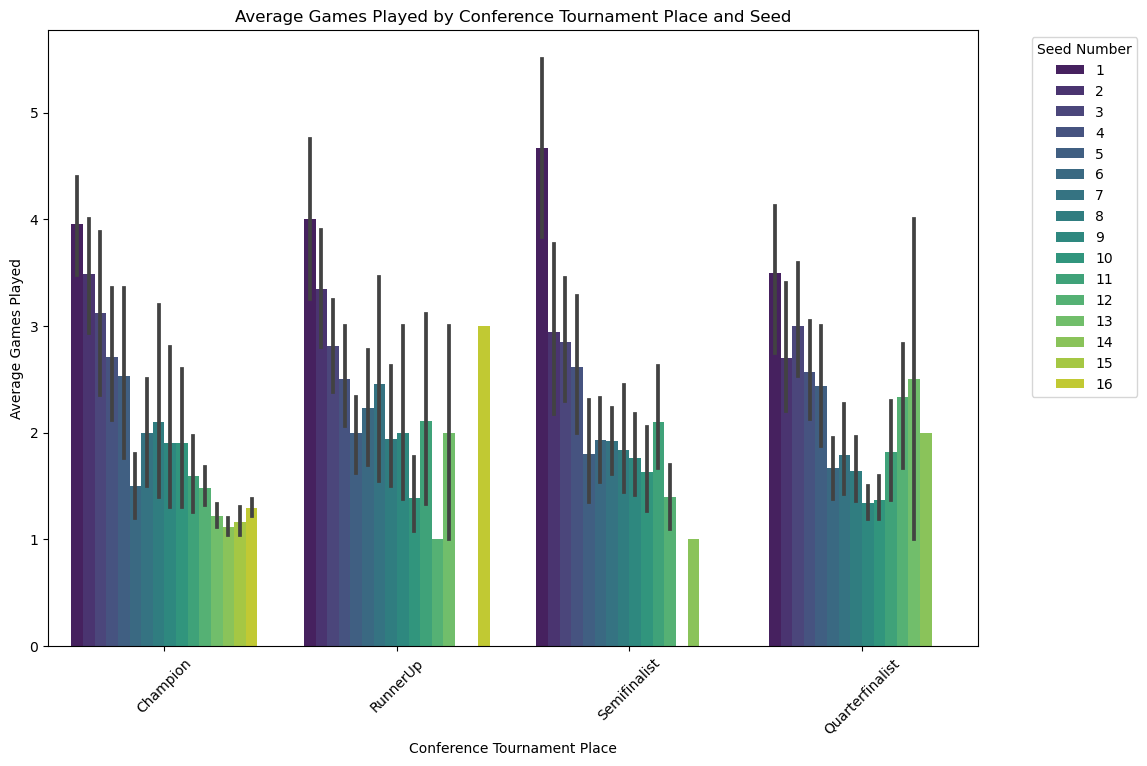

In [148]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top8conftourneyResults, x='ConfTournamentPlace', y='GamesPlayed', hue='SeedNum', palette="viridis")
plt.title('Average Games Played by Conference Tournament Place and Seed')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Average Games Played')
plt.legend(title='Seed Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


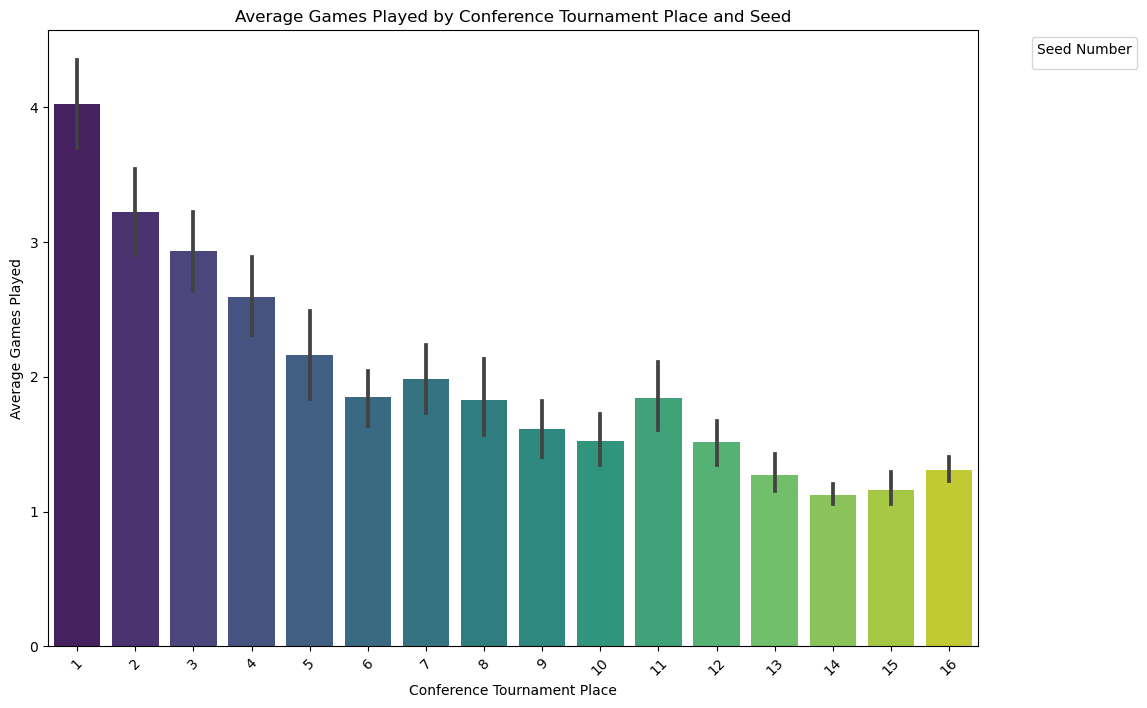

In [149]:
plt.figure(figsize=(12, 8))
sns.barplot(data=top8conftourneyResults,  y='GamesPlayed', x='SeedNum', palette="viridis")
plt.title('Average Games Played by Conference Tournament Place and Seed')
plt.xlabel('Conference Tournament Place')
plt.ylabel('Average Games Played')
plt.legend(title='Seed Number', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xticks(rotation=45)
plt.show()

In [152]:
import plotly.graph_objects as go
import numpy as np
df = top8conftourneyResults

# Assuming 'df' is your DataFrame with detailed game records, including SeedNum
# Calculate the average games played for each SeedNum
avg_games_played_by_seed = df.groupby('SeedNum')['GamesPlayed'].mean().reset_index()

# Sort the DataFrame by SeedNum to ensure the order is correct
avg_games_played_by_seed = avg_games_played_by_seed.sort_values(by='SeedNum')

# Calculate the deltas for the waterfall chart
# For the waterfall chart, the first delta is the average games played by the 1 seed
# Subsequent deltas are the changes from one seed to the next
deltas = np.diff(avg_games_played_by_seed['GamesPlayed'], prepend=avg_games_played_by_seed['GamesPlayed'].iloc[0])

# Adjust the measures array for the waterfall chart
measures = ['relative'] * len(deltas)
measures[0] = 'absolute'  # The first value is the starting point (absolute)

# Text for the annotations
text_values = [f"{delta:.2f}" if i != 0 else f"{avg_games_played_by_seed['GamesPlayed'].iloc[0]:.2f}" for i, delta in enumerate(deltas)]

# Create the waterfall chart
fig = go.Figure(go.Waterfall(
    name="Average Games Played",
    orientation="v",
    measure=measures,
    x=avg_games_played_by_seed['SeedNum'].astype(str).tolist(),
    textposition="outside",
    text=text_values,
    y=deltas,
    connector={"line":{"color":"rgb(63, 63, 63)"}},
))

fig.update_layout(
    title="Delta of Average Games Played by Seed Number <br>Team needed to finish 4th or better in conf tourney<br>Last 20 Years",
    xaxis_title="Seed Number",
    yaxis_title="Delta in Average Games Played",
    showlegend=True
)

fig.show()
print(avg_games_played_by_seed)

    SeedNum  GamesPlayed
0         1     4.026316
1         2     3.223684
2         3     2.933333
3         4     2.594595
4         5     2.162162
5         6     1.847222
6         7     1.985294
7         8     1.826087
8         9     1.611940
9        10     1.521739
10       11     1.845238
11       12     1.513158
12       13     1.273973
13       14     1.125000
14       15     1.162162
15       16     1.308411


#1s and #2s - not the same degree of elite 
#6,#7,#8,#11 - similar durations for tourney runs
#9,#10, #12 - not dead last, but pretty close

